<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/src/UMAP%2BClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UMAP + Clustering on Raw Data vs RNNs Hidden Representations
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

## Loading of Stringer spontaneous data



In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [4]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [5]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [6]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [7]:
# it can be done in one loop ... 
data_ = []

for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [8]:
# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

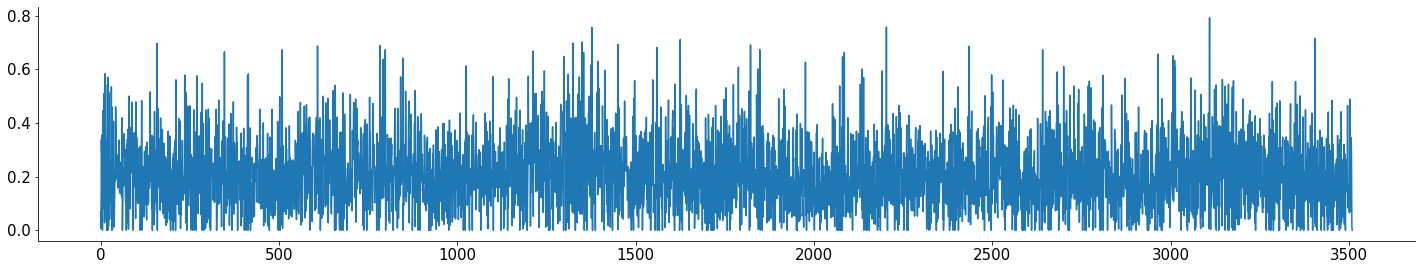

In [9]:
plt.plot(avgd_normed_dataRNN[0,:])

##  UMAP Visualization (Semi-Supervised) on Raw Data
The result is not encouraging, let's see if the RNN has captured some meaningful dynamics and UMAP can extract it in 2D.

In [10]:
!pip3 install umap-learn hdbscan --quiet

     |████████████████████████████████| 80 kB 5.1 MB/s 
     |████████████████████████████████| 6.4 MB 17.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 36.6 MB/s 


In [11]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split

In [12]:
b = np.ones(1131)
labels = np.hstack((0*b,b, 2*b, 3*b,4*b, 5*b, 6*b, 7*b, 8*b))

In [17]:
X_train,  X_test, y_train, y_test = train_test_split(avgd_normed_dataRNN, labels, test_size = 0.10, random_state = 2021)

In [20]:
#factor = 6 
emb = umap.UMAP(random_state = 2021, n_components=2, n_neighbors= 45, min_dist = 0.3).fit(X_train, y = y_train)

In [21]:
test_embedding = emb.transform(X_test)

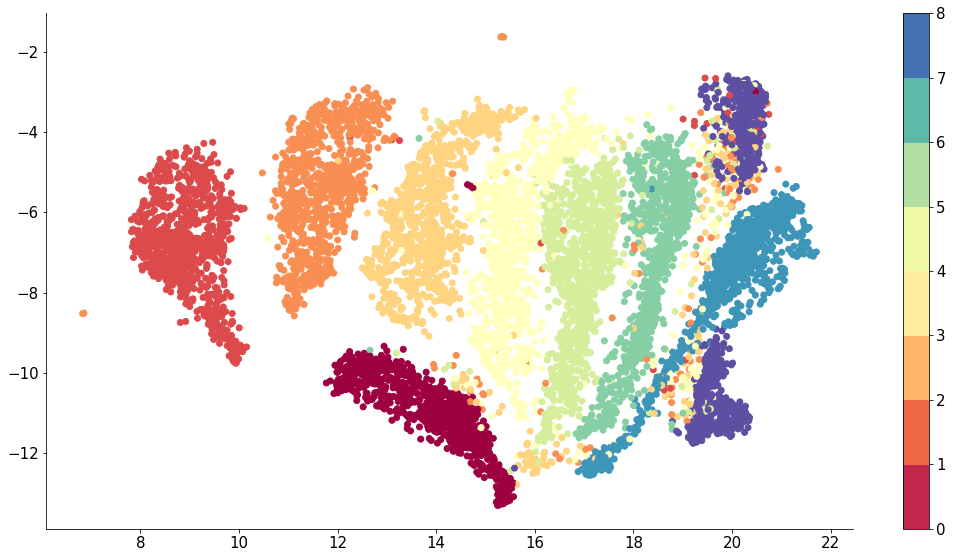

In [25]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*emb.embedding_.T,  c = y_train ,cmap = 'Spectral')
cbar = plt.colorbar(boundaries=np.arange(9))
cbar.set_ticks(np.arange(9))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])

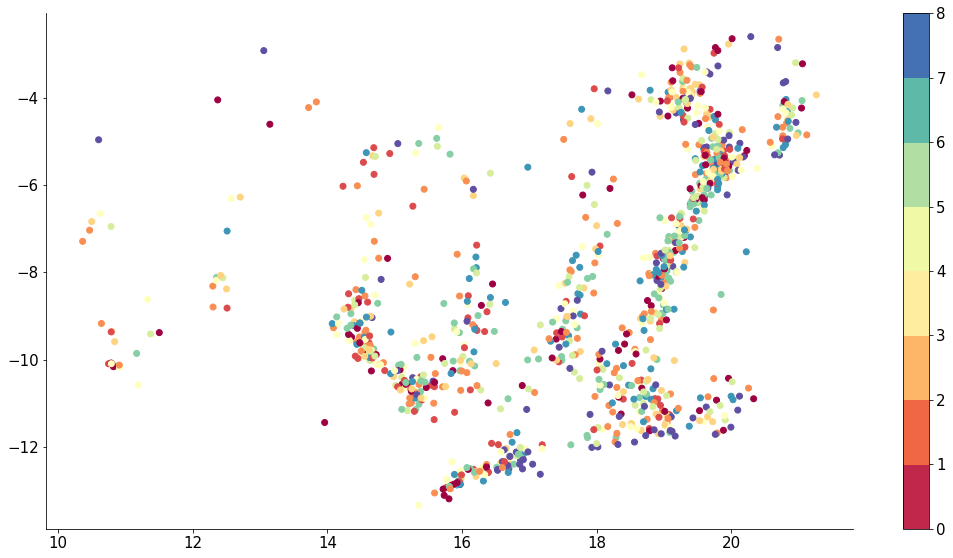

In [27]:
fig = plt.figure(figsize = (15, 8))
#ax = fig.add_subplot(projection='3d')
#plt.scatter(emb[:1131*factor,0], emb[:1131*factor,1], emb[:1131*factor, 2],  c = labels ,cmap = 'Spectral')
plt.scatter(*test_embedding.T,  c = y_test ,cmap = 'Spectral')
cbar = plt.colorbar(boundaries=np.arange(9))
cbar.set_ticks(np.arange(9))
cbar.set_ticklabels(["0", "1", "2", "3", "4", "5", "6", "7", "8"])

## UMAP on RNN's Reduced dynamics

### Extract Dynamics


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
torch.__version__ # should be 1.9.0 for training (Mish Activation)

'1.9.0+cu102'

In [ ]:
torch.load(net, "path")

In [ ]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [ ]:
frac = 4/5
n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = 75#int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [ ]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.2,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [ ]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer1 = torch.optim.Adam(net.parameters(), lr= 0.0003795, weight_decay= 10e-6)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[-0.0246],
          [-0.0236],
          [-0.0200],
          ...,
          [-0.0212],
          [-0.0207],
          [-0.0306]],
 
         [[-0.0641],
          [-0.0597],
          [-0.0608],
          ...,
          [-0.0718],
          [-0.0841],
          [-0.0718]],
 
         [[-0.1179],
          [-0.1076],
          [-0.1273],
          ...,
          [-0.1161],
          [-0.1150],
          [-0.1161]],
 
         ...,
 
         [[-0.0844],
          [-0.0664],
          [-0.0792],
          ...,
          [-0.0790],
          [-0.0817],
          [-0.0842]],
 
         [[-0.1031],
          [-0.0923],
          [-0.0826],
          ...,
          [-0.0868],
          [-0.0789],
          [-0.0952]],
 
         [[-0.0741],
          [-0.0754],
          [-0.0911],
          ...,
          [-0.0819],
          [-0.0836],
          [-0.0800]]], device='cuda:0', grad_fn=<PermuteBackward>),
 tensor([[[ 0.0639, -0.0152, -0.0546,  ...,  0.0009,  0.0238,  0.0009]],
 
 